In [110]:
import random
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import os
from joblib import dump, load
import numpy as np

from tensorflow.python.keras.models import Model

from code.nn_model.models import transformers
from code.read_data import get_data
from code.read_data import read_fnol_data

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score
import seaborn as sns
import pandas as pd
import warnings
import tensorflow as tf


warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

seed = 2022
# # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [111]:
cv_inner = StratifiedKFold(n_splits=5)

reg_RF = RandomForestClassifier(random_state=2022)
reg_lin = LogisticRegression()
reg_DT = DecisionTreeClassifier(random_state=2022, )
reg_MLP = MLPClassifier(random_state=2022)
reg_KN = KNeighborsClassifier()
reg_SVC = SVC(random_state=2022, probability=True, )
reg_adboost = AdaBoostClassifier(random_state=2022)

space_rf = dict()
space_rf['n_estimators'] = [i for i in range(1, 20, 1)]
space_rf['max_features'] = [i for i in range(1, 20)]
space_rf['max_depth'] = [i for i in range(2, 20)]
space_rf['criterion'] = ["gini", "entropy"]

space_lr = dict()
space_lr['C'] = np.linspace(0.0001, 10, 100)
space_lr['solver'] = ['newton-cg', 'lbfgs', 'sag', 'saga']
space_lr['max_iter'] = [i for i in range(1, 50)]

space_dt = dict()
space_dt['max_features'] = ["auto", "sqrt", "log2"]
space_dt['max_depth'] = [i for i in range(2, 20)]
space_dt['criterion'] = ["gini", "entropy"]

space_mlp = dict()
space_mlp['solver'] = ['lbfgs', 'sgd', 'adam']
space_mlp['hidden_layer_sizes'] = [i for i in range(2, 250)]
space_mlp['max_iter'] = [i for i in range(2, 150)]

space_kn = dict()
space_kn['n_neighbors'] = [i for i in range(2, 20)]
space_kn['weights'] = ['uniform', 'distance']
space_kn['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']

space_svc = dict()
space_svc['C'] = np.linspace(0.0001, 10, 100)
space_svc['kernel'] = ['poly', 'rbf']

space_adboost = dict()
space_adboost['learning_rate'] = np.linspace(0.001, 1, 10)
space_adboost['n_estimators'] = [i for i in range(1, 30)]

In [112]:
def prepare_data_with_nn_output(df):
    layers_output = []

    test_img, test_text, test_label = get_data(df)
    weight_path = "../nn_model/outputs/xray_class_weights.best.hdf5"

    model = transformers()
    model.load_weights(weight_path)

    layer_outputs = [layer.output for layer in model.layers[115:121]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    for i in range(0, test_img.shape[0]):
        activations = activation_model.predict(tf.expand_dims(test_img[i], axis=0))
        layers_output.append(activations[3][0])

    return np.array(layers_output), test_label


In [113]:
def addToResults(report_df, test_x, test_y, y_pred_lr, name, model, params_best):
    report = pd.DataFrame(columns={'Accuracy'}, data=[0])
    report['F1'] = f1_score(test_y, y_pred_lr, average="binary")
    report['Precision'] = precision_score(test_y, y_pred_lr, average="binary")
    report['Recall'] = recall_score(test_y, y_pred_lr, average="binary")
    report['Accuracy'] = model.score(test_x, test_y)
    report['Balanced Acc'] = balanced_accuracy_score(test_y, y_pred_lr)
    report['ROC-AUC'] = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1], )
    report['params'] = params_best

    report.index = [name]
    report_df = report_df.append(report)

    return report_df

In [114]:
def xval_test(model, space, df_report, train_x, train_y, test_x, test_y):
    acc_best = 0
    params_best = dict()
    num_iteration = 200
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=2022)

    for i in range(0, num_iteration):
        search = RandomizedSearchCV(model, space, scoring='accuracy', cv=cv_inner)
        result = search.fit(train_x, train_y)
        best_model = result.best_estimator_
        yhat_temp = best_model.predict(test_x)
        acc = accuracy_score(test_y, yhat_temp)
        if (acc_best < acc):
            best_model_save = best_model
            params_best = result.best_params_
            acc_best = acc
            yhat = yhat_temp
            dump(result, f'{type(best_model_save).__name__}.joblib')

    print(type(best_model_save).__name__)
    print('>acc=%.3f, cfg=%s' % (acc_best, params_best))
    print('Accuracy: %.3f ' % (acc_best))

    cm = confusion_matrix(test_y, yhat)

    # Plot confusion matrix
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = '{0}. Accuracy Score: {1}'.format(type(best_model_save).__name__, acc_best)
    plt.title(all_sample_title, size=15)

    plt.show()
    df_report = addToResults(df_report, test_x,
                             test_y, yhat, type(best_model_save).__name__, best_model_save, str(params_best))

    return df_report

In [115]:
train_df, test_df = read_fnol_data()

concat_train, train_y = prepare_data_with_nn_output(train_df)
concat_test, test_y = prepare_data_with_nn_output(test_df)

RandomForestClassifier
>acc=0.709, cfg={'n_estimators': 13, 'max_features': 17, 'max_depth': 7, 'criterion': 'gini'}
Accuracy: 0.709 


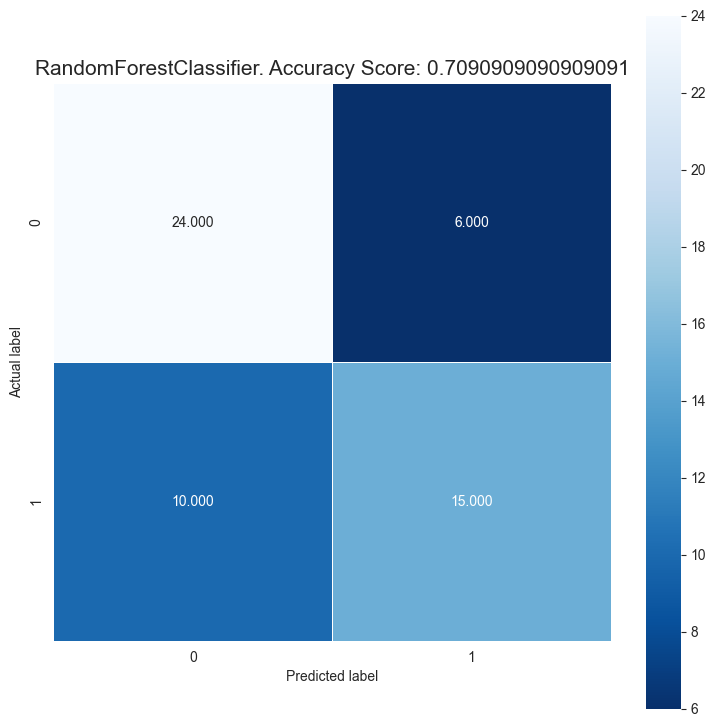

MLPClassifier
>acc=0.636, cfg={'solver': 'sgd', 'max_iter': 38, 'hidden_layer_sizes': 172}
Accuracy: 0.636 


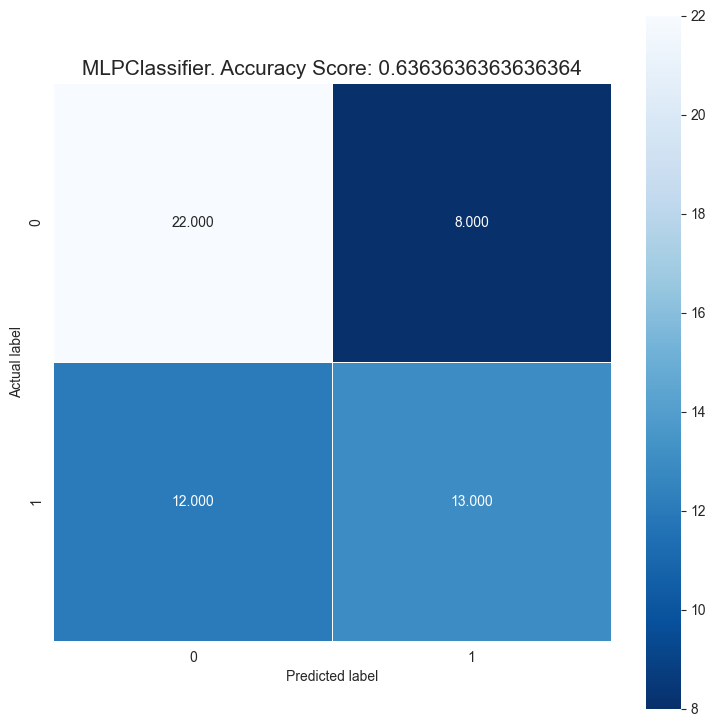

LogisticRegression
>acc=0.673, cfg={'solver': 'lbfgs', 'max_iter': 16, 'C': 4.949545454545454}
Accuracy: 0.673 


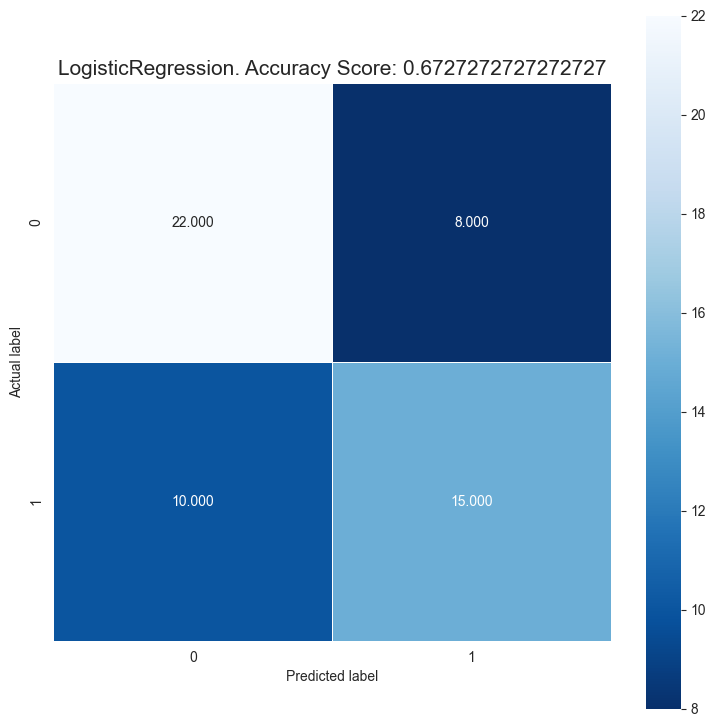

DecisionTreeClassifier
>acc=0.582, cfg={'max_features': 'auto', 'max_depth': 5, 'criterion': 'gini'}
Accuracy: 0.582 


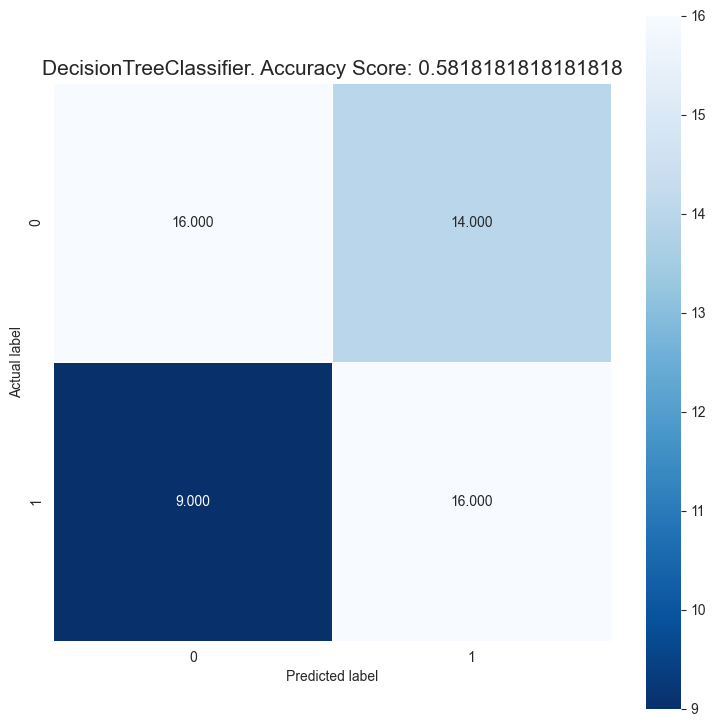

KNeighborsClassifier
>acc=0.618, cfg={'weights': 'uniform', 'n_neighbors': 5, 'algorithm': 'auto'}
Accuracy: 0.618 


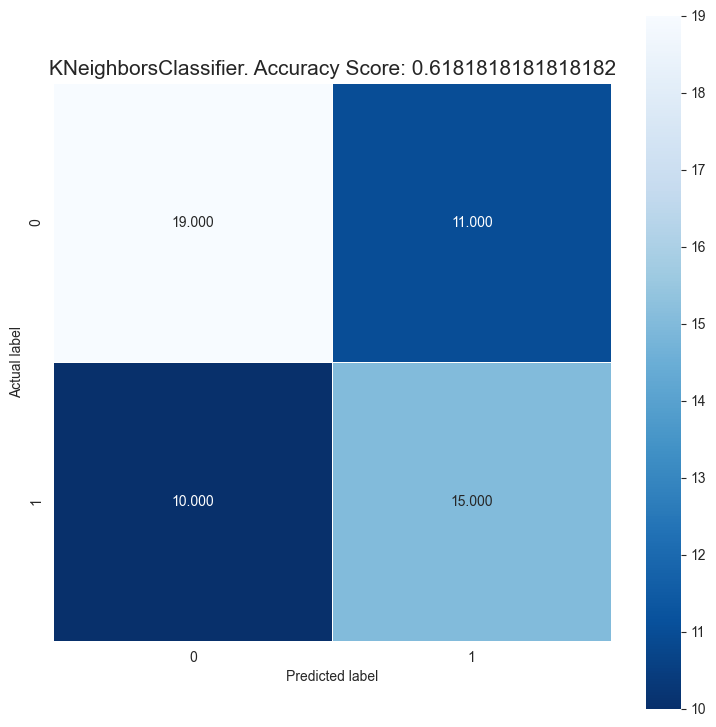

SVC
>acc=0.600, cfg={'kernel': 'rbf', 'C': 2.0202818181818185}
Accuracy: 0.600 


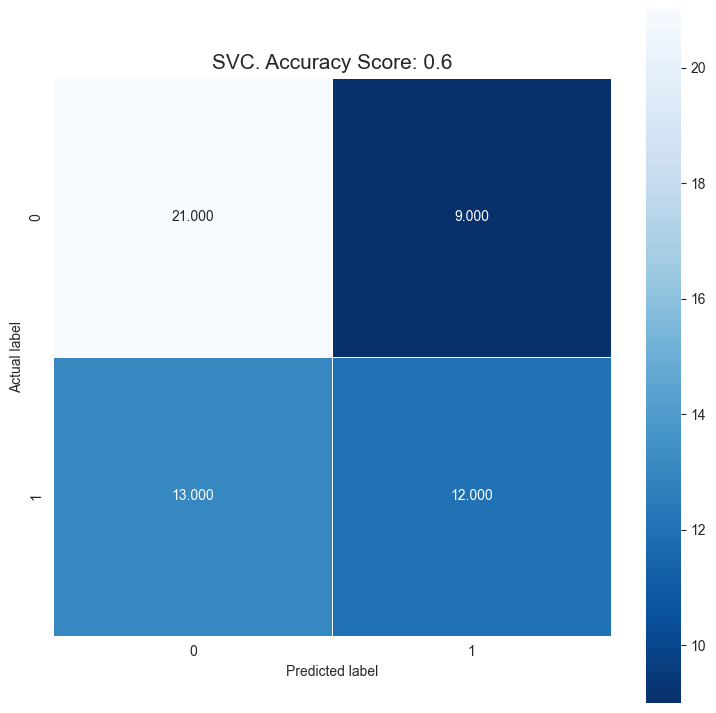

AdaBoostClassifier
>acc=0.655, cfg={'n_estimators': 24, 'learning_rate': 0.445}
Accuracy: 0.655 


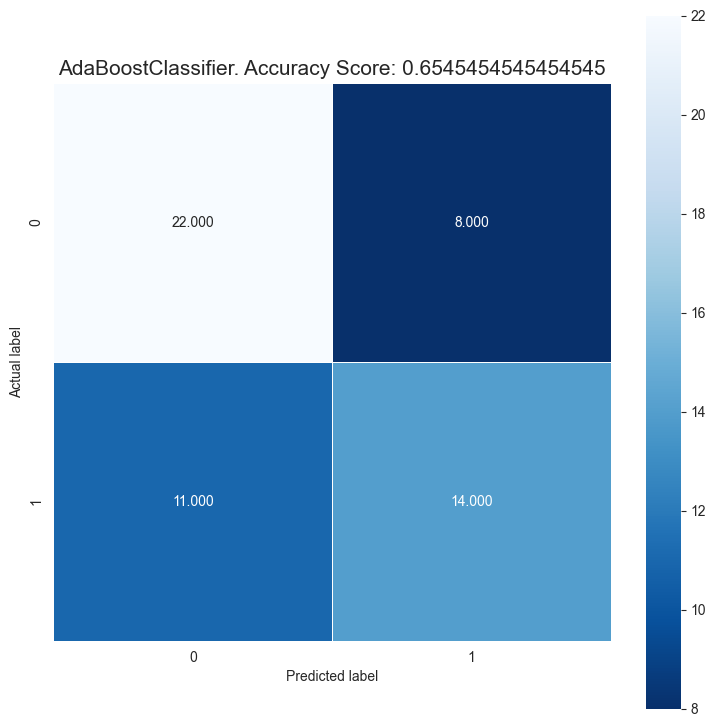

In [116]:
df_report_2 = pd.DataFrame()

df_report_2 = xval_test(reg_RF, space_rf, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_MLP, space_mlp, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_lin, space_lr, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_DT, space_dt, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_KN, space_kn, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_SVC, space_svc, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_adboost, space_adboost, df_report_2, concat_train, train_y, concat_test, test_y)

In [117]:
df_report_2

,Accuracy,F1,Precision,Recall,Balanced Acc,ROC-AUC,params
RandomForestClassifier,0.709091,0.652174,0.714286,0.60,0.700000,0.693333,"{'n_estimators': 13, 'max_features': 17, 'max_..."
MLPClassifier,0.636364,0.565217,0.619048,0.52,0.626667,0.680000,"{'solver': 'sgd', 'max_iter': 38, 'hidden_laye..."
LogisticRegression,0.672727,0.625000,0.652174,0.60,0.666667,0.600000,"{'solver': 'lbfgs', 'max_iter': 16, 'C': 4.949..."
DecisionTreeClassifier,0.581818,0.581818,0.533333,0.64,0.586667,0.564667,"{'max_features': 'auto', 'max_depth': 5, 'crit..."
KNeighborsClassifier,0.618182,0.588235,0.576923,0.60,0.616667,0.590667,"{'weights': 'uniform', 'n_neighbors': 5, 'algo..."
SVC,0.600000,0.521739,0.571429,0.48,0.590000,0.438000,"{'kernel': 'rbf', 'C': 2.0202818181818185}"
AdaBoostClassifier,0.654545,0.595745,0.636364,0.56,0.646667,0.636667,"{'n_estimators': 24, 'learning_rate': 0.445}"


0.6363636363636364


IndexError: list index out of range

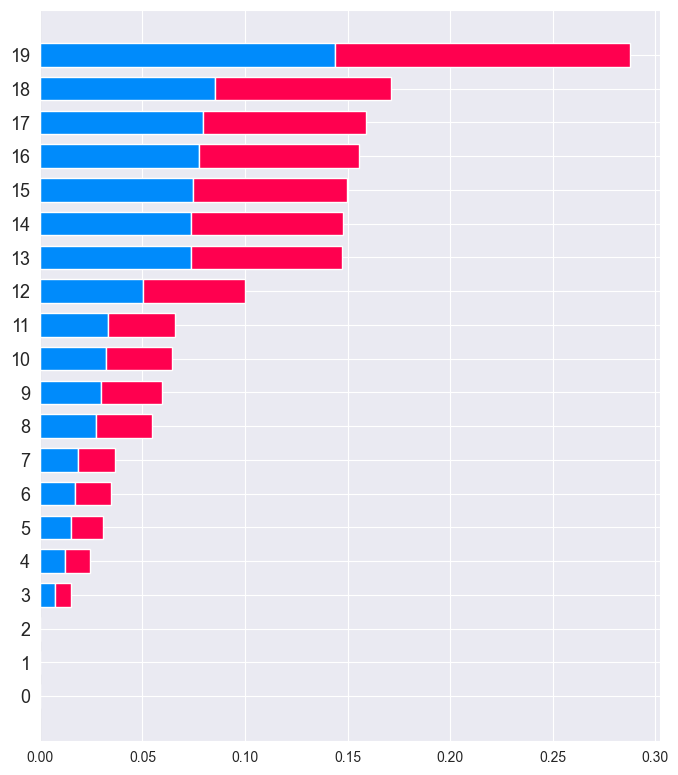

In [118]:
import shap

reg = RandomForestClassifier(random_state=2022, n_estimators=1, max_features=12, max_depth=9, criterion='gini')
reg.fit(concat_train, train_y)

r2_score = reg.score(concat_test, test_y)
print(r2_score)

shap_values = shap.TreeExplainer(reg, ).shap_values(concat_test)
shap.summary_plot(shap_values, concat_train,
                  feature_names=['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
                                 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
                                 'Pneumonia', 'Pneumothorax'], class_names=['No regression', 'Regression'], show=False)

In [ ]:
from sklearn.metrics import f1_score


def get_scores(report_df, model, X_test, y_test, name):
    report = pd.DataFrame(columns={'Accuracy'}, data=[0])
    report["Accuracy"] = model.score(X_test, y_test)
    report["Balanced accuracy"] = balanced_accuracy_score(y_test, model.predict(X_test))
    report['ROC-AUC'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    report['F1'] = f1_score(y_test, model.predict(X_test), average="macro")
    report['precision'] = precision_score(y_test, model.predict(X_test), average="macro")
    report['recall'] = recall_score(y_test, model.predict(X_test), average="macro")

    report.index = [name]
    report_df = report_df.append(report)
    return report_df


df_report = pd.DataFrame()
results_dict = {}

reg_RF = RandomForestClassifier(random_state=2022, n_estimators=1, max_features=10, max_depth=9, criterion="gini")
reg_lin = LogisticRegression(max_iter=10, solver="saga", C=0.6)
reg_DT = DecisionTreeClassifier(random_state=2022, class_weight='balanced', max_features='sqrt', max_depth=6,
                                criterion='gini')
reg_MLP = MLPClassifier(random_state=42, solver='lbfgs', max_iter=150, hidden_layer_sizes=(157))
reg_KN = KNeighborsClassifier(weights='distance', n_neighbors=8, algorithm="auto")
reg_SVC = SVC(random_state=42, probability=True, kernel="rbf", C=5.65)
reg_adboost = AdaBoostClassifier(random_state=2000, n_estimators=30, learning_rate=0.5)
# reg_xgboost = XGBClassifier(max_depth=5, objective='multi:softprob', eval_metric='logloss', num_class=2, seed=3)
# reg_catboost = CatBoostClassifier(verbose=False, learning_rate=0.6, max_depth=5)
# reg_lgbm = LGBMClassifier(class_weight='balanced', learning_rate=0.5, max_depth=3)

reg_list = [reg_RF, reg_lin, reg_DT, reg_MLP, reg_KN, reg_SVC, reg_adboost]

for reg in reg_list:
    #TRAIN AND TEST
    reg.fit(concat_train, train_y)
    score = reg.score(concat_test, test_y)
    print(type(reg).__name__)
    print(score)
    predicts = reg.predict(concat_test)
    cm = confusion_matrix(test_y, predicts)

    #Plot confusion matrix
    # plt.figure(figsize=(9, 9))
    # sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    # plt.ylabel('Actual label')
    # plt.xlabel('Predicted label')
    # all_sample_title = '{0}. Accuracy Score: {1}'.format(type(reg).__name__, score)
    # plt.title(all_sample_title, size=15)

    #Add to report
    df_report = get_scores(df_report, reg, concat_test,
                           test_y, type(reg).__name__)

In [ ]:
df_report